In [1]:
import os
import numpy as np
import pandas as pd
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from transformers import AutoTokenizer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix , accuracy_score , classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import shuffle
import platform
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.layers import Dense, Embedding, Conv1D, LSTM, Reshape, AveragePooling1D, GlobalMaxPooling1D, Input, MaxPooling1D, Dropout, Flatten,concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from keras import regularizers
seed=2023

In [2]:
print(platform.python_version())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.9.12
Num GPUs Available:  1


In [3]:
df0 = pd.read_csv("E:/CNSI_project/demo_and_data_5.0/Processed_data/MIMIC/aim2_dataAll_filtered_NameShorted.csv")
df0

,subject_id,hadm_id,chartdate,B_Albumin,B_AlkalinePhosphatase,B_Calcium,B_Chloride,B_LactateDehydrogenase,B_Phosphate,B_UreaNitrogen,...,age,resprate,acuity,Chief Complaint,icd_title,History of Present Illness,Past Medical History,Allergies,Family History,hospital_expire_flag
0,10001217,24597018,2157/11/19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55,16.0,3.0,"LEFT HAND PAINS, Left hand and face numbness, ...",Cerebral edema; Compression of brain; Family h...,Mrs. ___ is a ___ y/o F from ___ with history ...,Multiple sclerosis,Penicillins,"Mother with pancreatic cancer, brother-lung ca...",0
1,10003019,21616816,2174/9/18,2.6,NaN,10.4,102.0,NaN,2.8,32.0,...,72,16.0,2.0,"FEVER/MS CHANGES, confusion, rehab placement","Acute kidney failure, unspecified; Asthma, uns...","___ male w/ PMH of sarcoidosis, sleep apnea, n...","1. Sarcoidosis, dx skin bx:intestinal & pulmon...",Oxycodone / Ragweed,"Mother:___, cardiac disease. Father:diverticul...",0
2,10005808,26543907,2119/1/2,NaN,48.0,9.3,105.0,NaN,2.5,18.0,...,53,NaN,NaN,limb weakness and tingling,Acute infective polyneuritis,Mr. ___ is a ___ year old right handed gentlem...,Hiatal hernia in ___ Occasional heartburn,No Known Allergies / Adverse Drug Reactions,He has no family history of autoimmune disease...,0
3,10006269,27357430,2124/6/26,4.9,80.0,NaN,95.0,NaN,NaN,15.0,...,51,19.0,3.0,"Fever, Headache",Duodenitis without bleeding; Essential (primar...,NaN,NaN,No Known Allergies / Adverse Drug Reactions,NaN,0
4,10014078,25809882,2166/8/22,NaN,NaN,8.1,117.0,NaN,2.8,7.0,...,60,NaN,NaN,seizure,Benign neoplasm of cerebral meninges; Diabetes...,The pt is a ___ year-old woman who presents as...,hx of atypical meningioma - grade 2 - resected...,No Known Allergies / Adverse Drug Reactions,noncontributory,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5790,19994772,29219051,2181/4/18,NaN,NaN,NaN,103.0,150.0,NaN,9.0,...,55,20.0,2.0,Aletered mental status and fever,Abnormal involuntary movements; Candidiasis of...,___ is a ___ woman with,PAST MEDICAL HISTORY:Recurrent glioblastoma in...,Keflex,Non-contributory.,0
5791,19994772,29606061,2180/12/18,NaN,NaN,9.7,103.0,NaN,3.3,16.0,...,54,NaN,NaN,Recurrent glioblastoma.,"Cerebral aneurysm, nonruptured; Compression of...",Ms. ___ is a ___ y/o F s/p resection of gliobl...,Hyperlipidemia,___,non-contributory,0
5792,19995080,23057109,2147/7/13,2.3,961.0,7.5,105.0,NaN,2.3,17.0,...,59,NaN,NaN,Confusion- Altered Mental Status- transfer fro...,Calculus of gallbladder and bile duct without ...,___ M with AIDS and med non-compliance (CD4 20...,"- AIDS off ART prescribed for Truvada T qd, Ka...",Penicillins,Father died of AD at age ___. Mother died of D...,0
5793,19999784,24935234,2119/7/7,4.3,NaN,NaN,NaN,102.0,NaN,NaN,...,57,16.0,2.0,"Abnormal MRI, weakness",Abnormal cytological findings in cerebrospinal...,Mr. ___ is a ___ without significant medical h...,PAST ONCOLOGIC HISTORY:___ is a ___ right-hand...,No Known Allergies / Adverse Drug Reactions,Father had prostate cancer. Denies otherwise ...,0


In [4]:
df00 = df0.iloc[:,3:]
df00

,B_Albumin,B_AlkalinePhosphatase,B_Calcium,B_Chloride,B_LactateDehydrogenase,B_Phosphate,B_UreaNitrogen,B_Eosinophils,B_INR(PT),B_MCV,...,age,resprate,acuity,Chief Complaint,icd_title,History of Present Illness,Past Medical History,Allergies,Family History,hospital_expire_flag
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55,16.0,3.0,"LEFT HAND PAINS, Left hand and face numbness, ...",Cerebral edema; Compression of brain; Family h...,Mrs. ___ is a ___ y/o F from ___ with history ...,Multiple sclerosis,Penicillins,"Mother with pancreatic cancer, brother-lung ca...",0
1,2.6,NaN,10.4,102.0,NaN,2.8,32.0,NaN,NaN,78.0,...,72,16.0,2.0,"FEVER/MS CHANGES, confusion, rehab placement","Acute kidney failure, unspecified; Asthma, uns...","___ male w/ PMH of sarcoidosis, sleep apnea, n...","1. Sarcoidosis, dx skin bx:intestinal & pulmon...",Oxycodone / Ragweed,"Mother:___, cardiac disease. Father:diverticul...",0
2,NaN,48.0,9.3,105.0,NaN,2.5,18.0,3.2,NaN,87.0,...,53,NaN,NaN,limb weakness and tingling,Acute infective polyneuritis,Mr. ___ is a ___ year old right handed gentlem...,Hiatal hernia in ___ Occasional heartburn,No Known Allergies / Adverse Drug Reactions,He has no family history of autoimmune disease...,0
3,4.9,80.0,NaN,95.0,NaN,NaN,15.0,0.0,NaN,66.0,...,51,19.0,3.0,"Fever, Headache",Duodenitis without bleeding; Essential (primar...,NaN,NaN,No Known Allergies / Adverse Drug Reactions,NaN,0
4,NaN,NaN,8.1,117.0,NaN,2.8,7.0,NaN,NaN,76.0,...,60,NaN,NaN,seizure,Benign neoplasm of cerebral meninges; Diabetes...,The pt is a ___ year-old woman who presents as...,hx of atypical meningioma - grade 2 - resected...,No Known Allergies / Adverse Drug Reactions,noncontributory,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5790,NaN,NaN,NaN,103.0,150.0,NaN,9.0,0.3,NaN,92.0,...,55,20.0,2.0,Aletered mental status and fever,Abnormal involuntary movements; Candidiasis of...,___ is a ___ woman with,PAST MEDICAL HISTORY:Recurrent glioblastoma in...,Keflex,Non-contributory.,0
5791,NaN,NaN,9.7,103.0,NaN,3.3,16.0,0.2,NaN,93.0,...,54,NaN,NaN,Recurrent glioblastoma.,"Cerebral aneurysm, nonruptured; Compression of...",Ms. ___ is a ___ y/o F s/p resection of gliobl...,Hyperlipidemia,___,non-contributory,0
5792,2.3,961.0,7.5,105.0,NaN,2.3,17.0,0.3,1.1,94.0,...,59,NaN,NaN,Confusion- Altered Mental Status- transfer fro...,Calculus of gallbladder and bile duct without ...,___ M with AIDS and med non-compliance (CD4 20...,"- AIDS off ART prescribed for Truvada T qd, Ka...",Penicillins,Father died of AD at age ___. Mother died of D...,0
5793,4.3,NaN,NaN,NaN,102.0,NaN,NaN,0.6,NaN,84.0,...,57,16.0,2.0,"Abnormal MRI, weakness",Abnormal cytological findings in cerebrospinal...,Mr. ___ is a ___ without significant medical h...,PAST ONCOLOGIC HISTORY:___ is a ___ right-hand...,No Known Allergies / Adverse Drug Reactions,Father had prostate cancer. Denies otherwise ...,0


In [6]:
df00.hospital_expire_flag.value_counts()

0    5500
1     295
Name: hospital_expire_flag, dtype: int64

In [8]:
df0.hospital_expire_flag.value_counts()

0    5500
1     295
Name: hospital_expire_flag, dtype: int64

In [9]:
########### dataset 1 ########
df1 = df0.copy()
df1 = df1[["Chief Complaint","hospital_expire_flag"]]
df2 = df1.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# df2 = df2[df2['hospital_expire_flag'].notnull()]
# df2 = df2.dropna(thresh=2,axis=0)   # without even one Nan value
df2['hospital_expire_flag'] = df2['hospital_expire_flag'].astype(np.int16)
df2.rename(columns={'Chief Complaint':'English'},inplace=True)
df2

,English,hospital_expire_flag
0,"left hand pains, left hand and face numbness, ...",0
1,"fever/ms changes, confusion, rehab placement",0
2,limb weakness and tingling,0
3,"fever, headache",0
4,seizure,0
...,...,...
5790,aletered mental status and fever,0
5791,recurrent glioblastoma.,0
5792,confusion- altered mental status- transfer fro...,0
5793,"abnormal mri, weakness",0


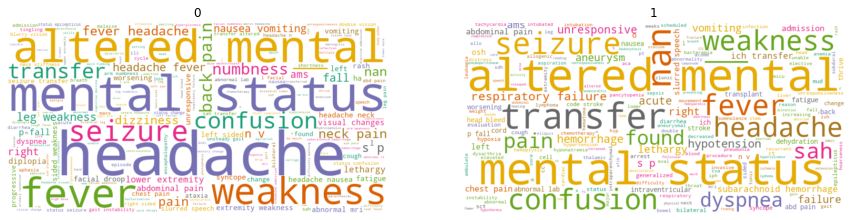

In [10]:
data = df2.copy()

# Group the data by label and concatenate the text data for each group
groups = data.groupby('hospital_expire_flag')['English'].apply(lambda x: ' '.join(str(i) for i in x))

# Generate a word cloud for each group
wordclouds = []
for group_name, group_data in groups.items():   # groups.items(): output keys and values in same time.
    # Create a word cloud object and generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2',random_state=2023).generate(group_data)
    wordclouds.append((group_name, wc))

# Plot the word clouds
fig, axs = plt.subplots(1, len(wordclouds), figsize=(15, 10))
for i, (group_name, wc) in enumerate(wordclouds):
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].set_title(group_name)
    axs[i].axis('off')

plt.show()

In [11]:
df_train_chief, df_test_chief = train_test_split(df2, test_size=0.2, random_state=seed, stratify=df2['hospital_expire_flag'])
df_train_chief

,English,hospital_expire_flag
918,"headache, n/v",0
1754,"overdose, requesting detoxification",0
3831,cerebellar hemorrhage,0
3261,s/p fall ~ 30 feet,0
1543,"headache, fevers and ha",0
...,...,...
5589,overnight numbness and paralysis from sternum ...,0
3700,"seizure, transfer, agitation, seizure",0
2647,"hypotension, weakness, fatigue, lightheadednes...",0
4068,"headache, facial droop, episode of emotional l...",0


In [12]:
df_train_chief.hospital_expire_flag.value_counts()

0    4400
1     236
Name: hospital_expire_flag, dtype: int64

In [13]:
df_test_chief.hospital_expire_flag.value_counts()

0    1100
1      59
Name: hospital_expire_flag, dtype: int64

In [14]:
########### dataset 2 ########
# loading structured data
df3 = df0.iloc[:,3:-7]
df3 = df3.loc[df2.index]

from sklearn.impute import KNNImputer
import pickle
imputer = KNNImputer(n_neighbors=5, weights='distance')

df_temp = imputer.fit_transform(df3)

with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/StandardPickleFiles/imputer_KNNImputer_aim2.pickle","wb") as f:
    pickle.dump(imputer, f)

df3 = pd.DataFrame(df_temp, columns=df3.columns.tolist(), index=df3.index)

df3['hospital_expire_flag'] = df2['hospital_expire_flag']

df_train_structured, df_test_structured = train_test_split(df3, test_size=0.2, random_state=seed, stratify=df3['hospital_expire_flag'])
df_train_structured

,B_Albumin,B_AlkalinePhosphatase,B_Calcium,B_Chloride,B_LactateDehydrogenase,B_Phosphate,B_UreaNitrogen,B_Eosinophils,B_INR(PT),B_MCV,...,B_WhiteBloodCells,C_LactateDehydrogenase,C_Protein,C_Eosinophils,C_Polys,C_RBC,age,resprate,acuity,hospital_expire_flag
918,3.989167,97.950659,8.600000,105.000000,358.358425,4.000000,18.0,5.334871,1.233333,84.666667,...,7.9,15.000000,65.0,2.231370,0.0,0.0,54.0,18.000000,2.000000,0
1754,3.800000,88.000000,8.600000,107.000000,282.000000,2.300000,6.0,2.174196,1.000000,89.000000,...,16.2,56.526572,40.0,1.361854,47.0,725.0,54.0,12.000000,2.000000,0
3831,3.600686,74.212573,9.300000,95.000000,279.002884,3.200000,14.0,1.840613,1.100000,80.000000,...,3.6,66.769096,37.0,3.010910,60.0,6800.0,74.0,21.028621,1.621295,0
3261,2.700000,89.121936,7.900000,104.000000,511.000000,3.000000,14.0,0.534978,1.100000,85.000000,...,10.3,89.019580,43.0,1.000000,94.0,1220.0,40.0,18.349861,2.211346,0
1543,3.500000,147.000000,8.653562,104.000000,234.808411,2.977631,9.0,1.000000,1.000000,91.000000,...,2.6,25.313947,29.0,3.428071,0.0,106.0,47.0,18.000000,3.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,2.100000,60.000000,8.200000,108.000000,224.000000,3.600000,8.0,2.055769,1.300000,92.000000,...,6.0,18.512892,27.0,1.218353,0.0,3.0,62.0,19.293465,2.397178,0
3700,3.800000,74.000000,8.900000,106.000000,285.099465,3.900000,14.0,0.100000,1.500000,96.000000,...,13.8,39.807361,51.0,1.664300,38.0,469.0,68.0,26.000000,2.000000,0
2647,3.763607,85.388820,9.000000,109.000000,286.582929,2.300000,8.0,1.000000,1.236761,90.000000,...,58.2,21.260439,44.0,2.182744,24.0,160.0,61.0,18.000000,1.000000,0
4068,4.215145,76.427360,9.965113,102.558463,183.195525,4.127534,20.0,1.600000,1.100000,90.000000,...,3.9,14.807330,22.0,5.628828,0.0,1.0,64.0,20.000000,3.000000,0


In [15]:
########### dataset 3 ########
df4 = df0.copy()
df4 = df4[["icd_title","hospital_expire_flag"]]
df4 = df4.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df4 = df4.loc[df2.index]
df4['hospital_expire_flag'] = df4['hospital_expire_flag'].astype(np.int16)
df4.rename(columns={'icd_title':'English'},inplace=True)

df_train_icd, df_test_icd = train_test_split(df4, test_size=0.2, random_state=seed, stratify=df4['hospital_expire_flag'])
df_train_icd

,English,hospital_expire_flag
918,"atypical chronic myeloid leukemia, bcr/abl-neg...",0
1754,acute respiratory failure with hypoxia; alcoho...,0
3831,acute respiratory failure; atrial fibrillation...,0
3261,accidental fall from ladder; accidents occurri...,0
1543,"anemia, unspecified; headache; leukocytopenia,...",0
...,...,...
5589,"asthma, unspecified type, unspecified; depress...",0
3700,adverse effect of antiallergic and antiemetic ...,0
2647,acidosis; acute posthemorrhagic anemia; acute ...,0
4068,arteriovenous malformation of cerebral vessels...,0


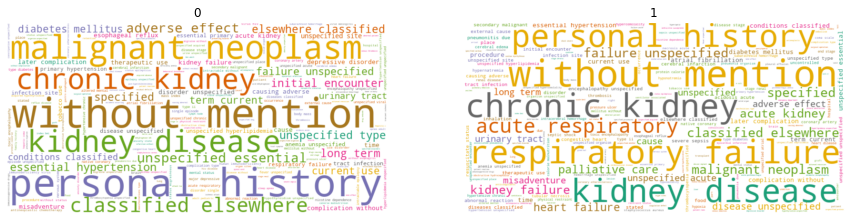

In [16]:
data = df4.copy()

# Group the data by label and concatenate the text data for each group
groups = data.groupby('hospital_expire_flag')['English'].apply(lambda x: ' '.join(str(i) for i in x))

# Generate a word cloud for each group
wordclouds = []
for group_name, group_data in groups.items():   # groups.items(): output keys and values in same time.
    # Create a word cloud object and generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2',random_state=2023).generate(group_data)
    wordclouds.append((group_name, wc))

# Plot the word clouds
fig, axs = plt.subplots(1, len(wordclouds), figsize=(15, 10))
for i, (group_name, wc) in enumerate(wordclouds):
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].set_title(group_name)
    axs[i].axis('off')

plt.show()

In [17]:
# Load BioBERTtokenizer and model
# pretrained_model = 'G:/BertModels/Bio_ClinicalBERT'
pretrained_model = 'G:/BertModels/BioBERT'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

In [18]:
def text2vec(df_text, col, token_length):
    #col = "Chief Complaint"
    sentences_maxlength = 1398
    sentences = df_text[col].fillna("").values.tolist()
    encoding = tokenizer(sentences, 
                         add_special_tokens=False, 
                         return_tensors='tf', 
                         padding='max_length', 
                         truncation=True, 
                         max_length=sentences_maxlength)

    input_ids = encoding['input_ids']
    input_ids1 = input_ids.numpy()
    
#     ICD:34, ChiefComplaint:20
    input_ids1_cumF95 = input_ids1[:,:token_length]
    
    return input_ids1_cumF95

In [19]:
# Change the data form, then merge them

#################### training set
X_train0 = text2vec(df_train_chief, 'English', 20)
X_train1 = df_train_structured.iloc[:,:-1].values

scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train1)

with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/StandardPickleFiles/scaler_aim2.pickle","wb") as f:
    pickle.dump(scaler, f)

X_train2 = text2vec(df_train_icd, 'English', 379)

X_train = np.concatenate([X_train0,X_train1,X_train2], axis=1)
y_train = df_train_chief['hospital_expire_flag'].values

#################### testing set
X_test0 = text2vec(df_test_chief, 'English', 20)
X_test1 = df_test_structured.iloc[:,:-1].values

X_test1 = scaler.transform(X_test1)
X_test2 = text2vec(df_test_icd, 'English', 379)

X_test = np.concatenate([X_test0,X_test1,X_test2], axis=1)
y_test = df_test_chief['hospital_expire_flag'].values

print(X_train.shape,X_test.shape)
X_train

(4636, 422) (1159, 422)


array([[16320.,   117.,   183., ...,     0.,     0.,     0.],
       [ 1166., 12847.,  1162., ...,     0.,     0.,     0.],
       [  172.,  9014., 23033., ...,     0.,     0.,     0.],
       ...,
       [  177.,  1183., 11439., ..., 14441.,  8974.,   117.],
       [16320.,   117., 14078., ...,     0.,     0.,     0.],
       [ 8599.,  4910.,  2781., ...,     0.,     0.,     0.]])

In [20]:
# Change the data form, then merge them

#################### training set
X_train0 = text2vec(df_train_chief, 'English', 20)
X_train1 = df_train_structured.iloc[:,:-1].values

scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train1)

with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/StandardPickleFiles/scaler_aim2.pickle","wb") as f:
    pickle.dump(scaler, f)

X_train2 = text2vec(df_train_icd, 'English', 379)

X_train = np.concatenate([X_train0,X_train1,X_train2], axis=1)
y_train = df_train_chief['hospital_expire_flag'].values

#################### testing set
X_test0 = text2vec(df_test_chief, 'English', 20)
X_test1 = df_test_structured.iloc[:,:-1].values
# 对structured data进行tandardScaler normalization
X_test1 = scaler.transform(X_test1)
X_test2 = text2vec(df_test_icd, 'English', 379)

X_test = np.concatenate([X_test0,X_test1,X_test2], axis=1)
y_test = df_test_chief['hospital_expire_flag'].values

print(X_train.shape,X_test.shape)
X_train

(4636, 422) (1159, 422)


array([[16320.,   117.,   183., ...,     0.,     0.,     0.],
       [ 1166., 12847.,  1162., ...,     0.,     0.,     0.],
       [  172.,  9014., 23033., ...,     0.,     0.,     0.],
       ...,
       [  177.,  1183., 11439., ..., 14441.,  8974.,   117.],
       [16320.,   117., 14078., ...,     0.,     0.,     0.],
       [ 8599.,  4910.,  2781., ...,     0.,     0.,     0.]])

In [21]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Training

In [21]:
# FCN
max_features = 28996+1
embed_dim = 128 
n_cols_text = 20
n_cols_numeric = 23
n_cols_icd = 379

def build_model():

    text_input = Input(shape=(n_cols_text,), dtype='int32')
    text_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_text)(text_input)
    text_flatten = Flatten()(text_embedding)

    numeric_input = Input(shape=(n_cols_numeric,))
    numeric_dense = Dense(128, activation='relu')(numeric_input)

    icd_input = Input(shape=(n_cols_icd,), dtype='int32')
    icd_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_icd)(icd_input)
    icd_flatten = Flatten()(icd_embedding)

    merged = concatenate([text_flatten, numeric_dense, icd_flatten])

    merged_dense = Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu')(merged)
    merged_dropout = Dropout(0.5)(merged_dense)
    output = Dense(2, activation='softmax')(merged_dropout)

    model = Model(inputs=[text_input, numeric_input, icd_input], outputs=output)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
# CNN
max_features = 28996+1
embed_dim = 128
n_cols_text = 20
n_cols_numeric = 23
n_cols_icd = 379

def build_model():

    text_input = Input(shape=(n_cols_text,), dtype='int32')
    text_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_text)(text_input)

    numeric_input = Input(shape=(n_cols_numeric,))
    numeric_dense = Dense(128, activation='relu')(numeric_input)
    # Reshape numeric input to have a temporal dimension
    numeric_reshaped = Reshape((1, -1))(numeric_dense)  # Reshape to shape (batch_size, 1, n_cols_numeric)

    icd_input = Input(shape=(n_cols_icd,), dtype='int32')
    icd_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_icd)(icd_input)

    merged = concatenate([text_embedding, numeric_reshaped, icd_embedding], axis=1)   # Concatenate along the time axis

    merged_dense = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(merged)
    merged_pool = AveragePooling1D(pool_size=2)(merged_dense)

    merged_flat = Flatten()(merged_pool)  # Flatten the output for the Dense layer
    merged_dropout = Dropout(0.5)(merged_flat)
#     merged_dropout = Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu')(merged_dropout)
#     merged_dropout = Dropout(0.5)(merged_dropout)
    output = Dense(2, activation='softmax')(merged_dropout)

    model = Model(inputs=[text_input, numeric_input, icd_input], outputs=output)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# LSTM
max_features = 28996+1
embed_dim = 128
lstm_out = 128
n_cols_text = 20
n_cols_numeric = 23
n_cols_icd = 379

def build_model():

    text_input = Input(shape=(n_cols_text,), dtype='int32')
    text_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_text)(text_input)
    lstm_output_text = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.0)(text_embedding)

    numeric_input = Input(shape=(n_cols_numeric,))
    numeric_dense = Dense(128, activation='relu')(numeric_input)

    icd_input = Input(shape=(n_cols_icd,), dtype='int32')
    icd_embedding = Embedding(input_dim=max_features, output_dim=embed_dim, input_length=n_cols_icd)(icd_input)
    lstm_output_icd = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.0)(icd_embedding)

    merged = concatenate([lstm_output_text, numeric_dense, lstm_output_icd])

    merged_dense = Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu')(merged)
    merged_dropout = Dropout(0.5)(merged_dense)
    output = Dense(2, activation='softmax')(merged_dropout)

    model = Model(inputs=[text_input, numeric_input, icd_input], outputs=output)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = build_model()
model.fit([X_train[:,:20],X_train[:,20:20+23],X_train[:,20+23:]], y_train, epochs = 2, batch_size = 64, verbose = 1, class_weight=class_weights)

In [785]:
# save model
# model.save()

In [ ]:
# model = load_model()

In [40]:
# load model
from tensorflow.keras.models import load_model
# model = load_model('E:/CNSI_project/demo_and_data_5.0/models_v2.1/aim2_selected/Aim2_ChiefStructuredICD_FCN.h5')
# model = load_model('E:/CNSI_project/demo_and_data_5.0/models_v2.2/Aim2_ChiefStructuredICD_CNN.h5')
model = load_model('E:/CNSI_project/demo_and_data_5.0/models_v2.1/aim2_selected/Aim2_ChiefStructuredICD_LSTM.h5')

# Testing

In [41]:
X_test_text = X_test[:,:20]
X_test_numeric = X_test[:,20:20+23]
X_test_icd = X_test[:,20+23:]
y_test

array([0, 0, 0, ..., 0, 1, 0], dtype=int16)

In [42]:
score,acc = model.evaluate([X_test_text,X_test_numeric,X_test_icd], y_test, verbose = 2)
print("score: %.3f" % (score))
print("acc: %.3f" % (acc))

37/37 - 2s - loss: 0.6117 - accuracy: 0.7981 - 2s/epoch - 62ms/step
score: 0.612
acc: 0.798


In [43]:
predict_test = model.predict([X_test_text,X_test_numeric,X_test_icd])
predict_test

37/37 [==============================] - 2s 22ms/step


array([[0.84522307, 0.15477699],
       [0.92555046, 0.0744495 ],
       [0.9401834 , 0.05981652],
       ...,
       [0.9982889 , 0.00171101],
       [0.07724901, 0.92275107],
       [0.94548887, 0.05451107]], dtype=float32)

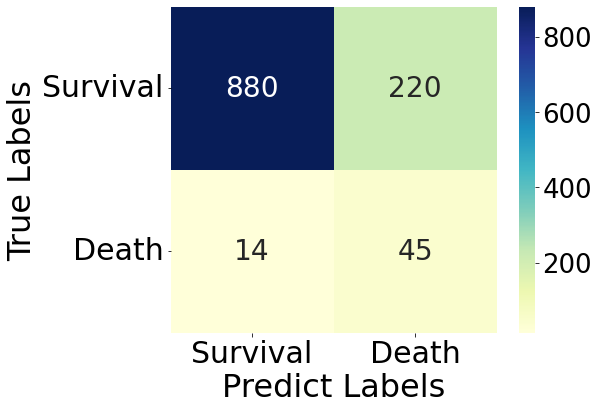

In [44]:
# generate confusion matrix
labels1 = ["Survival", "Death"]
plt.figure(figsize = (8, 6))
cm = confusion_matrix(y_test, np.argmax(predict_test,axis=1))
ax = sns.heatmap(cm, square=True, annot=True , cmap="YlGnBu", annot_kws={"fontsize":28}, fmt=".0f")   #square=True, annot=True showing number
# plt.matshow(cm)
# plt.title('Confusion matrix DNN', fontsize=18)
plt.ylabel("True Labels", fontsize=32)
plt.xlabel("Predict Labels", fontsize=32)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

# plt.colorbar()
plt.xticks([i + 0.5 for i in range(len(labels1))], labels1, rotation = 0, fontsize=30)
plt.yticks([i + 0.5 for i in range(len(labels1))], labels1, rotation = 0, fontsize=30)

plt.show()

In [45]:
cm

array([[880, 220],
       [ 14,  45]], dtype=int64)

In [46]:
predict_matrix = np.zeros(cm.shape)
for i in range(cm.shape[0]):
    temp = np.sum(cm[i])
    for j in range(cm.shape[1]):
        predict_matrix[i,j] = cm[i,j]/temp

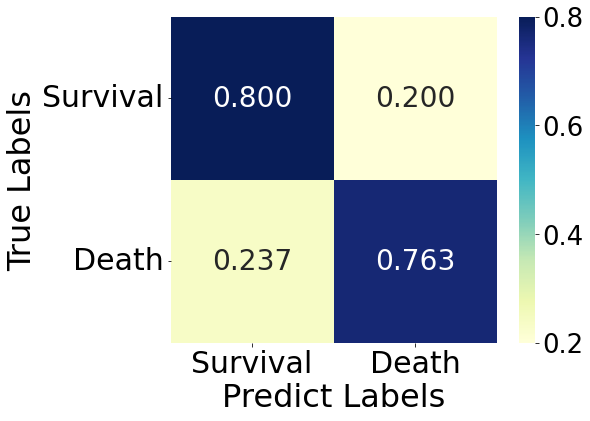

In [47]:
plt.figure(figsize = (8, 6))
ax = sns.heatmap(predict_matrix, square=True, annot=True ,cmap="YlGnBu", annot_kws={"fontsize":28}, fmt=".3f")
plt.xticks([i + 0.5 for i in range(len(predict_matrix))], labels1, rotation = 0, fontsize=30)
plt.yticks([i + 0.5 for i in range(len(predict_matrix))], labels1, rotation = 0, fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

# plt.title('Confusion matrix of prediction', fontsize=18)
plt.ylabel("True Labels", fontsize=32)
plt.xlabel("Predict Labels", fontsize=32)

plt.show()

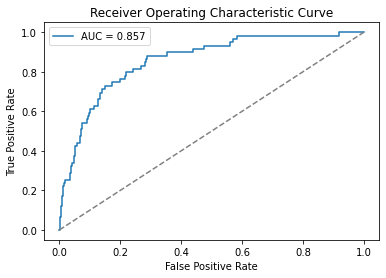

In [48]:
# Calculate AUC score and plot ROC curve
auc = roc_auc_score(y_test, predict_test[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predict_test[:,1])

plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

In [34]:
# FCN
y_test_3final_nn1 = y_test.copy()
y_predict_3final_nn1 = predict_test.copy()

with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/AUCpickle/NN1_3final.pickle","wb") as f:
    pickle.dump([y_test_3final_nn1,y_predict_3final_nn1], f)

In [100]:
# CNN
y_test_3final_nn2 = y_test.copy()
y_predict_3final_nn2 = predict_test.copy()

with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/AUCpickle/NN2_3final.pickle","wb") as f:
    pickle.dump([y_test_3final_nn2,y_predict_3final_nn2], f)

In [68]:
# LSTM
y_test_3final_nn3 = y_test.copy()
y_predict_3final_nn3 = predict_test.copy()

with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/AUCpickle/NN3_3final.pickle","wb") as f:
    pickle.dump([y_test_3final_nn3,y_predict_3final_nn3], f)

In [94]:
# calculate evaluation metric using test cohort
accuracy0 = np.round(accuracy_score(y_test, 
               np.argmax(predict_test,axis=1)), decimals = 3)
print('\n1dCNN Predictive Accuracy: ',accuracy0)


1dCNN Predictive Accuracy:  0.85


In [95]:
print('\nSummary of 1dCNN Precision and Recall\n') 
print(classification_report(y_test, np.argmax(predict_test,axis=1), 
                            target_names = labels1, digits=3))


Summary of 1dCNN Precision and Recall

              precision    recall  f1-score   support

    Survival      0.990     0.850     0.915      1100
       Death      0.233     0.847     0.365        59

    accuracy                          0.850      1159
   macro avg      0.612     0.849     0.640      1159
weighted avg      0.952     0.850     0.887      1159



In [96]:
y_true = np.array(y_test).flatten()
y_true = y_true.astype(int)
y_pred = predict_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 

# The weights for each class
weights = np.bincount(y_true) / len(y_true)

# Weighted average sensitivity and specificity
weighted_avg_sensitivity = np.sum(weights * np.array([TPR, TNR]))
weighted_avg_specificity = np.sum(weights * np.array([TNR, TPR]))

print('Weighted avg sensitivity:', weighted_avg_sensitivity)
print('Weighted avg specificity:', weighted_avg_specificity)

Weighted avg sensitivity: 0.8475870490340883
Weighted avg specificity: 0.8498705780845557


# AUPRC、C-index and Brier Score

FCN AUPRC: 0.499
Baseline (positive class ratio): 0.051


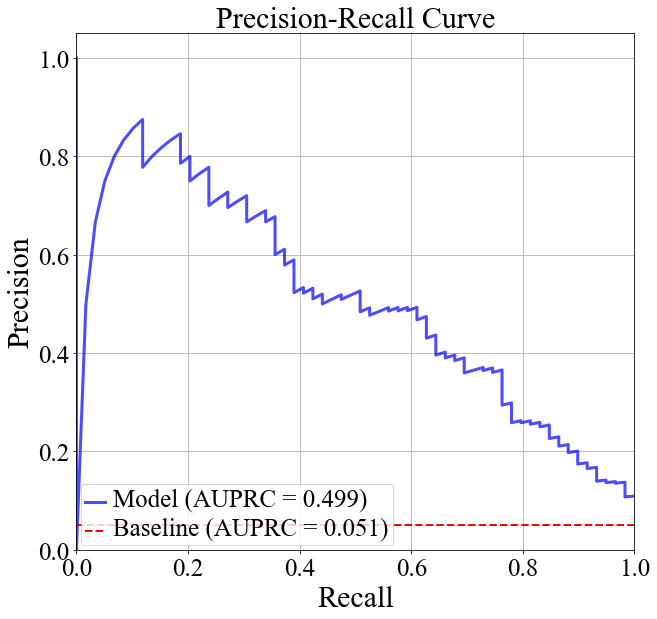

In [97]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, brier_score_loss
from lifelines.utils import concordance_index

# AUPRC
precision, recall, _ = precision_recall_curve(y_test, predict_test[:, 1])
auprc = auc(recall, precision)
print(f'FCN AUPRC: {auprc:.3f}')

baseline = sum(y_test) / len(y_test)
print(f'Baseline (positive class ratio): {baseline:.3f}')

plt.figure(figsize=(10, 9.5))
plt.plot(recall, precision, color='blue', label=f'Model (AUPRC = {auprc:.3f})', linewidth=3, alpha=0.7)

plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline (AUPRC = {baseline:.3f})', linewidth=2)

plt.xlabel('Recall', fontsize=30, fontname='Times New Roman')
plt.ylabel('Precision', fontsize=30, fontname='Times New Roman')
plt.title('Precision-Recall Curve', fontsize=30, fontname='Times New Roman')

legend = plt.legend(loc='lower left')
for text in legend.get_texts():
    text.set_fontname('Times New Roman')
    text.set_fontsize(25)

plt.grid()

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=25, fontname='Times New Roman')
plt.yticks(fontsize=25, fontname='Times New Roman')

plt.show()

In [98]:
# C-index
c_index = concordance_index(y_test, predict_test[:,1])
print(f'FCN C-index: {c_index:.3f}')

FCN C-index: 0.933


In [99]:
# Brier Score 
brier_score = brier_score_loss(y_test, predict_test[:,1])
print(f'FCN Brier Score: {brier_score:.3f}')

FCN Brier Score: 0.114
